# LGBM을 활용한 베이스라인

In [1]:
import pandas as pd
import os
import random

## 1. 데이터 로딩

In [81]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
DATA_PATH = '/opt/ml/input/data/train_dataset/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

### 1-1 DB 로딩

In [82]:
student_grade = pd.read_csv("/opt/ml/input/data/DB/student_grade.csv")
test_info = pd.read_csv("/opt/ml/input/data/DB/test_info.csv")
correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
correct_t.columns = ["test_mean", 'test_sum']
correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
correct_k.columns = ["tag_mean", 'tag_sum']

In [83]:
student_grade = student_grade[["userID","grade","acc","elapsed"]]
test_info = test_info[["testId","problem_number","type_number","acc","elapsed"]]

In [84]:
student_grade.columns = ["userID","grade","grade_acc","grade_elapsed"]
test_info.columns = ["testId","problem_count","type_count","test_acc","test_elapsed"]

In [85]:
student_grade

,userID,grade,grade_acc,grade_elapsed
0,0,2,0.722222,37.206897
1,0,6,0.791908,36.533784
2,0,8,0.468320,39.261981
3,1,4,0.822719,96.679204
4,1,9,0.903409,103.672297
...,...,...,...,...
19734,7439,4,0.733333,38.384615
19735,7440,3,0.400000,29.125000
19736,7440,5,0.400000,18.600000
19737,7441,3,0.200000,44.000000


In [86]:
test_info

,testId,problem_count,type_count,test_acc,test_elapsed
0,A010000001,5,1,0.923429,33.949286
1,A010000002,5,2,0.931429,34.218902
2,A010000003,5,3,0.842857,36.326211
3,A010000004,5,3,0.880571,34.215713
4,A010000005,5,2,0.849143,36.883227
...,...,...,...,...,...
1532,A090000070,8,4,0.461153,41.475362
1533,A090000071,8,5,0.345000,40.847059
1534,A090000072,6,2,0.453333,45.295547
1535,A090000073,6,3,0.536667,23.459677


## 2. Feature Engineering

In [87]:
def add_col(df):
    pre = df["testId"][0]
    count = df["answerCode"][0]
    c = 1
    new = []

    for idx, answer in zip(df["testId"],df["answerCode"]):
        if pre != idx :
            pre = idx
            new.append(0)
            c = 1
            count = answer
        else :
            new.append(count/c)
            c += 1
            count += answer
    df['cum_correct'] = new
    return df

In [88]:
def add_last_problem(df):
    new = []
    pre = df['testId'][0]
    for idx in df['testId']:
        if pre != idx :
            new[-1]=-1
            pre = idx
        new.append(0)
    df['last_problem'] = new
    return df

In [89]:
def feature_engineering(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    df = add_col(df)
    df = add_last_problem(df)
    print('1', df.columns)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']
    print('2', df.columns)
    
    diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
    diff = diff.fillna(pd.Timedelta(seconds=0))
    diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

    # 푸는 시간
    df['elapsed'] = diff
    df['elapsed'] = df['elapsed'].apply(lambda x : x if x <650 else None)
    # 앞 세자리 
    # 중간 세자리
    # 문제 번호
    df['grade']=df['testId'].apply(lambda x : int(x[1:4])//10)
    df['mid'] = df['testId'].apply(lambda x : int(x[-3:]))
    df['problem_number'] = df['assessmentItemID'].apply(lambda x : int(x[-3:]))
    
    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    
    print('3', df.columns)

    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    print('4', df.columns)

    df = pd.merge(df, student_grade, on=['userID','grade'], how="left")
    
    print('5', df.columns)

    df = pd.merge(df, test_info, on=['testId'], how="left")

    print('6', df.columns)
    
    return df

In [90]:
df = feature_engineering(df)
df.head()

1 Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'cum_correct', 'last_problem'],
      dtype='object')
2 Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'cum_correct', 'last_problem', 'user_correct_answer',
       'user_total_answer', 'user_acc'],
      dtype='object')
1 Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'cum_correct', 'last_problem', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'elapsed', 'grade', 'mid',
       'problem_number', 'test_mean', 'test_sum'],
      dtype='object')
1 Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'cum_correct', 'last_problem', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'elapsed', 'grade', 'mid',
       'problem_number', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum'],
      dtype='object')
1 Index(['userID', 'as

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,cum_correct,last_problem,user_correct_answer,user_total_answer,...,test_mean,test_sum,tag_mean,tag_sum,grade_acc,grade_elapsed,problem_count,type_count,test_acc,test_elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1.0,0,NaN,0,...,0.947683,1268.0,0.955022,637.0,0.791908,36.533784,7,2,0.952667,20.842105
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,0,1.0,1,...,0.947683,1268.0,0.913187,3040.0,0.791908,36.533784,7,2,0.952667,20.842105
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1.0,0,2.0,2,...,0.947683,1268.0,0.913187,3040.0,0.791908,36.533784,7,2,0.952667,20.842105
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1.0,0,3.0,3,...,0.947683,1268.0,0.913187,3040.0,0.791908,36.533784,7,2,0.952667,20.842105
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1.0,0,4.0,4,...,0.947683,1268.0,0.913187,3040.0,0.791908,36.533784,7,2,0.952667,20.842105


In [91]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'cum_correct', 'last_problem', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'elapsed', 'grade', 'mid',
       'problem_number', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum',
       'grade_acc', 'grade_elapsed', 'problem_count', 'type_count', 'test_acc',
       'test_elapsed'],
      dtype='object')

## 3. Train/Test 데이터 셋 분리

In [92]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [30]:
# 마지막 문제만 추출
df = df[df['last_problem']==-1].copy()

In [93]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc', 'test_mean', 'test_sum', 'tag_mean','tag_sum',
         'problem_number', 'elapsed', 'grade',
         'grade_acc', 'grade_elapsed', 'problem_count', 'type_count', 'test_acc','test_elapsed'
        ]

# ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
#        'KnowledgeTag', 'cum_correct', 'user_correct_answer',
#        'user_total_answer', 'user_acc', 'elapsed', 'grade', 'mid',
#        'problem_number', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum',
#        'grade_acc', 'grade_elapsed', 'problem_count', 'type_count', 'test_acc',
#        'test_elapsed']

# categorical 처리!!!


# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [33]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [94]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [95]:
model = lgb.train(
                    {'objective': 'binary','mertric':'auc'}, 
                    lgb_train,
                    valid_sets=[lgb_train, lgb_test],
                    verbose_eval=100,
                    num_boost_round=3000,
                    early_stopping_rounds=200
                )

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

[LightGBM] [Warning] Unknown parameter: mertric
[LightGBM] [Warning] Unknown parameter: mertric
[LightGBM] [Info] Number of positive: 1039062, number of negative: 547095
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3353
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 17
[LightGBM] [Warning] Unknown parameter: mertric
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655081 -> initscore=0.641451
[LightGBM] [Info] Start training from score 0.641451
Training until validation scores don't improve for 200 rounds
[100]	training's binary_logloss: 0.477436	valid_1's binary_logloss: 0.527045
[200]	training's binary_logloss: 0.471847	valid_1's binary_logloss: 0.518648
[300]	training's binary_logloss: 0.467284	valid_1's binary_logloss: 0.512776

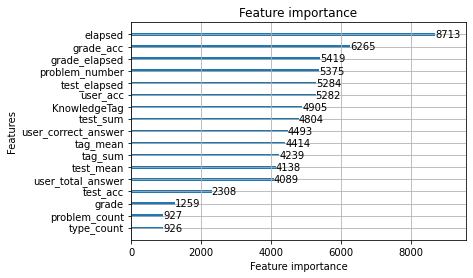

In [96]:
# INSTALL MATPLOTLIB IN ADVANCE
import matplotlib.pyplot as plt
_ = lgb.plot_importance(model)

## 5. Inference

In [97]:
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
test_csv_file_path = '/opt/ml/input/data/train_dataset/test_data.csv'
test_df = pd.read_csv(test_csv_file_path, dtype=dtype, parse_dates=['Timestamp'])
test_df = test_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

In [98]:
test_df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag'],
      dtype='object')

In [99]:
# FEATURE ENGINEERING
test_df = feature_engineering(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

1 Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'cum_correct', 'last_problem'],
      dtype='object')
2 Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'cum_correct', 'last_problem', 'user_correct_answer',
       'user_total_answer', 'user_acc'],
      dtype='object')
1 Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'cum_correct', 'last_problem', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'elapsed', 'grade', 'mid',
       'problem_number', 'test_mean', 'test_sum'],
      dtype='object')
1 Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'cum_correct', 'last_problem', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'elapsed', 'grade', 'mid',
       'problem_number', 'test_mean', 'test_sum', 'tag_mean', 'tag_sum'],
      dtype='object')
1 Index(['userID', 'as

In [100]:
test_df.head(10)

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,cum_correct,last_problem,user_correct_answer,user_total_answer,user_acc,...,test_mean,test_sum,tag_mean,tag_sum,grade_acc,grade_elapsed,problem_count,type_count,test_acc,test_elapsed
1035,3,A050133008,A050000133,2020-10-26 13:13:57,5289,0.857143,-1,717.0,1035,0.692754,...,0.653970,1219.0,0.560703,1658.0,0.655052,63.258152,8,2,0.655328,71.882009
1706,4,A070146008,A070000146,2020-12-27 02:47:54,9080,0.857143,-1,465.0,670,0.694030,...,0.635949,697.0,0.538664,1226.0,0.703529,65.061170,8,2,0.651883,68.405588
3023,13,A070111008,A070000111,2020-12-27 04:35:09,9660,0.428571,-1,915.0,1316,0.695289,...,0.462209,795.0,0.499044,1305.0,0.390593,22.142523,8,3,0.456728,39.127758
4283,17,A090064006,A090000064,2020-10-30 05:48:37,2611,1.000000,-1,1031.0,1259,0.818904,...,0.427536,236.0,0.408974,319.0,0.924757,55.127479,6,1,0.445743,42.072727
4670,26,A060135007,A060000135,2020-10-23 11:44:18,1422,0.666667,-1,293.0,386,0.759067,...,0.634492,986.0,0.610038,2589.0,0.817365,41.003559,7,1,0.640366,63.961745
5524,29,A020190005,A020000190,2020-10-22 04:38:45,8097,1.000000,-1,723.0,853,0.847597,...,0.740972,1067.0,0.712804,2199.0,0.891667,46.907090,5,1,0.739827,58.245017
6608,45,A040136005,A040000136,2020-10-23 08:24:19,2107,0.250000,-1,746.0,1083,0.688827,...,0.736264,1005.0,0.708647,3016.0,0.556075,79.701220,5,1,0.721815,49.997490
7301,53,A040140005,A040000140,2020-10-26 09:13:20,2110,0.500000,-1,362.0,692,0.523121,...,0.722556,961.0,0.714736,2493.0,0.511416,39.562030,5,2,0.713235,30.707155
8112,58,A070159007,A070000159,2020-12-24 21:09:29,9122,0.142857,-1,295.0,810,0.364198,...,0.470930,810.0,0.363158,552.0,0.230645,14.046555,8,3,0.477978,48.670908
9382,64,A070146008,A070000146,2020-12-29 04:30:22,9080,1.000000,-1,1058.0,1269,0.833727,...,0.635949,697.0,0.538664,1226.0,0.617486,9.619335,8,2,0.651883,68.405588


In [101]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [102]:
# SAVE OUTPUT
output_dir = '/opt/ml/output/'
write_path = os.path.join(output_dir, "LGBM_add_feature_full.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : /opt/ml/output/LGBM_add_feature_full.csv
